In [1]:
using Revise

In [2]:
using UnPack

In [4]:
using ImmersedLayers

In [3]:
using HeatForecastAnyShape

In [5]:
using CairoMakie

In [6]:
using LaTeXStrings

In [7]:
using Distributions
using Random
using LinearAlgebra
using GaussianMixtures
using Statistics

In [8]:
using JLD2

### True data

In [9]:
δ_true = 0.01
zq = [0.5+1.2im]
qq = [1.0]
c1q = [0.5]
c2q = [0.25]
Nq_true = length(zq)

1

### Set some plotting themes

In [10]:
xytheme = Theme(
        Axis = (aspect=DataAspect(),xlabel=L"x",ylabel=L"y"),
        palette = (color = Makie.wong_colors(),),
        Lines = (cycle = [:color],),
        Scatter = (cycle = [:color],)
    );

sensortheme = Theme(
    Axis = (xlabel="Sensor no.",ylabel=L"T-T_{ref}") # xticks=1:length(sens),
);

### Set up the observer for the true data

In [11]:
config_true, x_true = get_config_and_state(zq,qq,c1q,c2q)
ϵmeas_data = [1e-5,1e-4,2.5e-4,3.75e-4,5e-4,6.25e-4,8e-4,1e-3,1.5e-3,2e-3,3e-3,4e-3];
x_true

5-element Vector{Float64}:
 0.5
 1.2
 1.0
 0.5
 0.25

### Heater Estimation

In [12]:
Nq_estimator = 1
δ = 0.01
config_estimator = HeaterConfig(Nq_estimator)


# ranges to confine the prior mean to
xr = (-2.0,2.0)
yr = (0.01,2) #(0.01,4) #(0.01,2.0)
qr = (-2,2)
c1r = (0,1)
c2r = (0,1)
bounds = create_state_bounds(xr,yr,qr,c1r,c2r,config_estimator);
bounds

5-element Vector{Tuple{Float64, Float64}}:
 (-2.0, 2.0)
 (0.01, 2.0)
 (-2.0, 2.0)
 (0.0, 1.0)
 (0.0, 1.0)

In [13]:
#bounds for numerical domain
xr = (-2.0,2.0)
yr = (-2.0,2.0) #(0.01,4) #(0.01,2.0)
qr = (-2,2)
c1r = (0,1)
c2r = (0,1)
bounds_num = create_state_bounds(xr,yr,qr,c1r,c2r,config_estimator);
bounds_num

5-element Vector{Tuple{Float64, Float64}}:
 (-2.0, 2.0)
 (-2.0, 2.0)
 (-2.0, 2.0)
 (0.0, 1.0)
 (0.0, 1.0)

### Set up the MCMC parameters

In [14]:
## Parallel tempering ##
propvarX_coarse = 0.01^2 
propvarY_coarse = 0.01^2
propvarQ_coarse = 0.05^2 #0.05^2
propvarC_coarse = 0.01^2

propvarX_fine = 0.005^2 # 0.01^2
propvarY_fine = 0.005^2 # 0.01^2
propvarQ_fine = 0.01^2 # 0.005^2 # 0.01^2
propvarC_fine = 0.005^2

#Ntrial = [10000, 600000]
#propvar = [state_covariance(propvarX_coarse,propvarY_coarse,propvarQ_coarse,propvarR_coarse,config_estimator),
           #state_covariance(propvarX_fine,propvarY_fine,propvarQ_fine,propvarR_fine,config_estimator)];
Ntrial = [10000]
propvar = [state_covariance(propvarX_coarse,propvarY_coarse,propvarQ_coarse,propvarC_coarse,config_estimator)];

### Getting results for a specific case

In [15]:
Δx = 0.01
Ntheta = 500
gridConfig = constructGrids(Δx,bounds_num;Ntheta)

constructGrids{Tuple{Float64, Float64}, BasicILMCache{0, GridScaling, Nodes{Primal, 408, 408, Float64, Matrix{Float64}}, 2, BodyList, VectorData{0, Float64, Vector{Float64}}, ScalarData{0, Float64, Vector{Float64}}, Regularize{0, false}, RegularizationMatrix{Edges{Primal, 408, 408, Float64, Vector{Float64}}, VectorData{0, Float64, Vector{Float64}}}, InterpolationMatrix{Edges{Primal, 408, 408, Float64, Vector{Float64}}, VectorData{0, Float64, Vector{Float64}}}, RegularizationMatrix{Nodes{Primal, 408, 408, Float64, Matrix{Float64}}, ScalarData{0, Float64, Vector{Float64}}}, InterpolationMatrix{Nodes{Primal, 408, 408, Float64, Matrix{Float64}}, ScalarData{0, Float64, Vector{Float64}}}, Nothing, Nothing, Nothing, Nothing, Laplacian{408, 408, Float64, true, false}, Edges{Primal, 408, 408, Float64, Vector{Float64}}, Nodes{Dual, 408, 408, Float64, Matrix{Float64}}, Nothing, VectorData{0, Float64, Vector{Float64}}, ScalarData{0, Float64, Vector{Float64}}, Nothing}}(0.01, (-2.0, 2.0), (-2.0, 2.

In [16]:
K = 1
Nsens = 5
ϵmeas = 5e-4
obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsens,ϵmeas,x_true,config_true,gridConfig)
logp̃_fcn, obs = setup_estimator(obs_true.sens,bounds,config_estimator,ystar,Σϵ,gridConfig);

In [17]:
ystar

5-element Vector{Float64}:
 -0.8348591168958508
 -0.8029232710704508
 -0.7710057426082357
 -0.7489701713605066
 -0.7508582077436516

In [37]:
xseed = generate_random_state(bounds,obs.config)
gm, x_decorr_data = find_gmm(K,logp̃_fcn,obs,xseed,Ntrial,propvar,nskip=10);

In [38]:
xm, Σ, wts = means_and_covariances(gm,config_estimator);

Σh = [Σ[j] for j = 1:length(Σ)];

In [39]:
xm

5×1 transpose(::Matrix{Float64}) with eltype Float64:
 0.5686703460007531
 1.2750207286691597
 1.4915310289614794
 0.4036743239462182
 0.28628937638959406

In [40]:
Σh

1-element Vector{Matrix{Float64}}:
 [0.0016509484071389224 0.0003517119493264677 … -0.000356034716702488 -0.0008152353166176352; 0.0003517119493264677 0.0055827194650534834 … 0.008513397154138019 0.004753332240517156; … ; -0.000356034716702488 0.008513397154138019 … 0.015223960657198214 0.007902418074997421; -0.0008152353166176352 0.004753332240517156 … 0.007902418074997421 0.004949406644211457]

In [ ]:
@save "MCMC.jld2" gm x_decorr_data xmean=xm Σ Σh wts

In [ ]:
@load "MCMC.jld2" gm x_decorr_data xmean Σ Σh wts

In [ ]:
xm = copy(xmean)

In [53]:
#plottype = :samples
plottype = :heater

saveplot = true

ds_string = string(1000+round(Int,100*abs(obs.sens[end]-obs.sens[1])/(length(obs.sens)-1)))[2:end]
ns_string = string(length(obs.sens))
nq_string = string(obs.config.Nq)
K_string = string(K)

delta_string = string(round(Int,1000+100*δ_true))[2:4]

filename = nq_string*"heater-1truth-K"*K_string*"-delta"*delta_string*"-"*ns_string*"sensor-ds"*ds_string*"-noise5em4"
#filename = nv_string*"vortex-1truth-K"*K_string*"-delta"*delta_string*"-"*ns_string*"sensorcirc-ds"*ds_string*"-noise5em4"

"1heater-1truth-K1-delta001-5sensor-ds050-noise5em4"

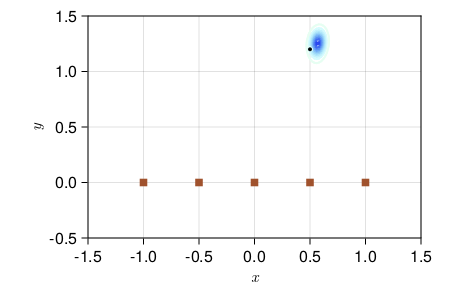

In [59]:
_, best_comp = findmax(wts)

with_theme(xytheme) do
    f = Figure(;resolution=(450,300))
    ax = f[1,1] = Axis(f)

    if plottype == :samples
        show_singularity_samples!(ax,x_decorr_data,obs,nskip=1,markersize=3) #colormap=:Set1_3:RdBu_3,nskip=1)
        #singularity_ellipses!(ax,xm[:,best_comp],Σ[best_comp],obs,color=:red)
        singularity_ellipses!(ax,xm,Σ,wts,obs,fill=false)
        
        singularity_ellipses!(ax,x_true,Σx,obs_true,color=(:black,0.2),fill=true,strokewidth=0.5)
        
        # Draw some lines to indicate maximum uncertainty direction at true state
        #=
        xid, yid, Γid = get_singularity_ids(obs_true.config)
        F = svd(H,full=true)
        vmax = F.Vt[end,:]
        for j = 1:number_of_singularities(obs_true.config)
            lines!(ax,[real(zv)[j]-vmax[xid[j]],real(zv)[j]+vmax[xid[j]]],[imag(zv)[j]-vmax[yid[j]],imag(zv)[j]+vmax[yid[j]]],color=:black,linewidth=0.5)
        end
        =#
    
    elseif plottype == :heater
        hmin, hmax = -1.5,1.5 #-0.25,0.25
        lev = range(hmin,hmax,length=20)
        plot_expected_sourcefield!(ax,xm,Σh,obs,xlims=(-2,2),ylims=(-1,2.5),colormap=cgrad(:lighttemperaturemap,rev=true),linewidth=2,colorrange=(hmin,hmax),levels=lev)
        
        #comp = 9 # best_comp
        #plot_expected_sourcefield!(ax,xm[:,comp],Σ[comp],obs,ylims=(-1,2.5),colormap=cgrad(:lighttemperaturemap,rev=true),linewidth=2,colorrange=(wmin,wmax),levels=lev)

        Σ_true = state_covariance(δ_true^2,δ_true^2,0.0,0.0,config_true);        
        plot_expected_sourcefield!(ax,x_true,Σ_true,obs_true,ylims=(-1,2),colormap=cgrad(:lighttemperaturemap,rev=true),linestyle=:dot,linewidth=1,colorrange=(hmin,hmax),levels=lev)
        
    end
    
    #lines!(ax,real(zc),imag(zc);marker=:none,color=:gray)
    #lines!(ax,[0.0,real(z0)],[0.0,imag(z0)],marker=:none,color=:gray)

    scatter!(ax,real(zq),imag(zq),marker=:circle,markersize=4,color=:black,strokewidth=1)
  
    plot_sensors!(ax,obs,color=:sienna)
    #ylims!(ax,(-0.5,2))
    #xlims!(ax,(-1.5,1.5))
    ylims!(ax,(-0.5,1.5))
    xlims!(ax,(-1.5,1.5))
    
    fullname = String(plottype)*"-"*filename*".svg" 
    saveplot && save(fullname,f)
    f
end

In [60]:
import CairoMakie.GeometryBasics as GB

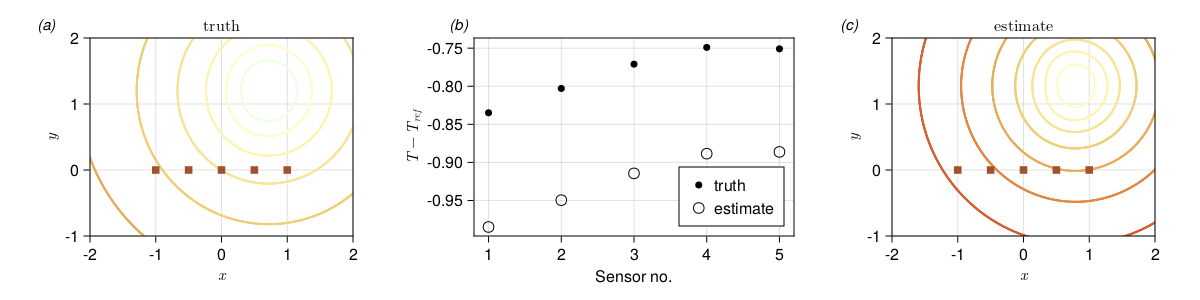

In [61]:
t = 0.0
_, best_comp = findmax(wts)
comp = best_comp
l = range(-12,0.01,length=21)
cl = (-1,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)
Tmin, Tmax = -1,-0.2
plot_temperature_field!(axleft,x_true,obs_true,gridConfig,colormap=cgrad(:lighttemperaturemap,rev=true),colorrange=(Tmin,Tmax),levels=range(Tmin,Tmax,length=15),linewidth=2)
plot_sensors!(axleft,obs_true,color=:sienna)
plot_temperature_field!(axright,xm[:,comp],obs,gridConfig,mode=:relative,colormap=cgrad(:lighttemperaturemap,rev=true),colorrange=(Tmin,Tmax),levels=range(Tmin,Tmax,length=15),linewidth=2)
plot_sensors!(axright,obs,color=:sienna)


# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(obs.sens),xlabel="Sensor no.",ylabel=L"T-T_{ref}") 
plot_sensor_data!(axcenter,ystar,xm[:,comp],t,obs,gridConfig;sensor_noise=ϵmeas*ones(length(ystar)))
axislegend(axcenter,position=:rb)


for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
saveplot && save("Temperaturefield-"*filename*".svg",f)

f

In [20]:
x_decorr_data

Ensemble with 501 members of 5-dimensional data
5×501 Matrix{Float64}:
 1.33006     0.582439  0.582439  0.582439  …  0.466235  0.466235  0.466235
 1.53104     1.43315   1.43315   1.43315      1.20993   1.20993   1.20993
 0.623932    0.576778  0.576778  0.576778     0.665111  0.665111  0.665111
 0.724553    0.634965  0.634965  0.634965     0.606888  0.606888  0.606888
 0.00164398  0.413606  0.413606  0.413606     0.31795   0.31795   0.31795

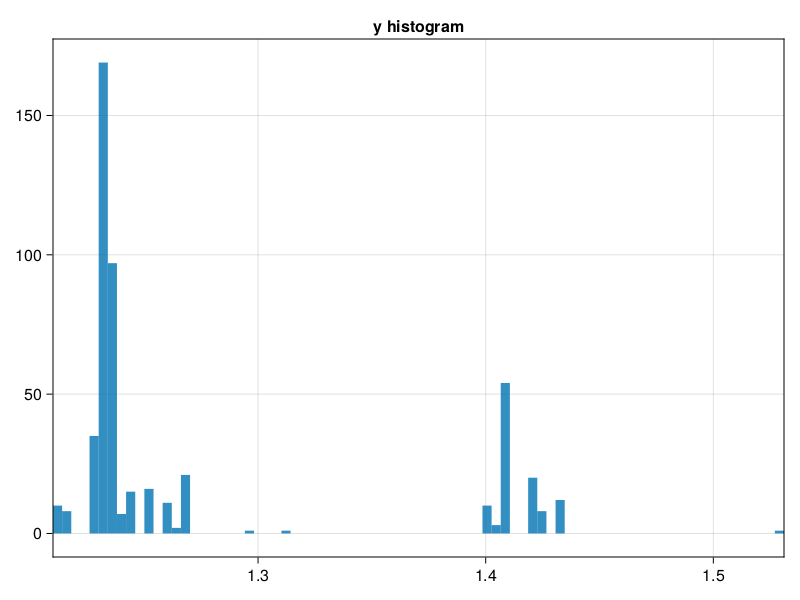

In [33]:
data_histogram(x_decorr_data[2,:];bins=80,xlims = (minimum(x_decorr_data[2,:]),maximum(x_decorr_data[2,:])), title="y histogram")